In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing as pre
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [2]:
# Load data
data = pd.read_csv('final-dataset.csv')

In [3]:
# Drop non-relevant columns and extract features/labels
X = data.drop(columns=['Signal', 'Label', 'Hurst Component'])
y = data['Label']

# Scale features
X = pre.scale(X)

In [4]:
# Reshape X to 3D for LSTM (samples, timesteps, features)
X = X.reshape(X.shape[0], 1, X.shape[1])  # Assuming single timestep

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [5]:
# ========================= LSTM Model =========================
def create_lstm_model(optimizer='adam', units=64, dropout_rate=0.5):
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units // 2))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# Wrap the model for GridSearchCV
model = KerasClassifier(build_fn=create_lstm_model, verbose=0)


C:\Users\Yash Srivastava\AppData\Local\Temp\ipykernel_13528\1303027398.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm_model, verbose=0)


In [7]:
# Hyperparameter grid
parameters_lstm = {
    'batch_size': [16, 32],
    'epochs': [50, 100],
    'optimizer': ['adam', 'rmsprop'],
    'units': [64, 128],
    'dropout_rate': [0.2, 0.5]
}


In [8]:
# Perform Grid Search for LSTM model
grid_search_lstm = GridSearchCV(estimator=model, param_grid=parameters_lstm, n_jobs=-1, cv=3)
grid_search_lstm.fit(X_train, y_train)

# Best model
best_model_lstm = grid_search_lstm.best_estimator_


In [9]:
# Predict using LSTM model
y_pred_lstm = best_model_lstm.predict(x_test)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)  # Convert probabilities to binary labels


7/7 [==============================] - 0s 1ms/step


In [10]:
# ========================= Model Evaluation =========================
tn_lstm, fp_lstm, fn_lstm, tp_lstm = confusion_matrix(y_test, y_pred_lstm).ravel()
specificity_lstm = tn_lstm / (tn_lstm + fp_lstm)
accuracy_lstm = (tp_lstm + tn_lstm) / (tp_lstm + tn_lstm + fp_lstm + fn_lstm)
sensitivity_lstm = tp_lstm / (tp_lstm + fn_lstm)
precision_lstm= (tp_lstm/(tp_lstm+fp_lstm))
f1_Score = 2 * (precision_lstm * sensitivity_lstm) / (precision_lstm + sensitivity_lstm)

print("LSTM Model Metrics:")
print(f"Specificity: {specificity_lstm}")
print(f"Accuracy: {accuracy_lstm}")
print(f"Sensitivity: {sensitivity_lstm}")
print(f"precision:{precision_lstm}")
print(f"f1_Score: {f1_Score}")


LSTM Model Metrics:
Specificity: 0.7358490566037735
Accuracy: 0.8095238095238095
Sensitivity: 0.8846153846153846
precision:0.7666666666666667
f1_Score: 0.8214285714285715


7/7 [==============================] - 0s 2ms/step


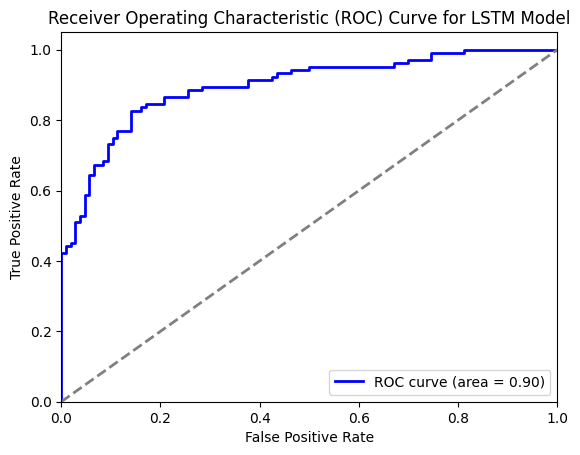

In [11]:
# ========================= ROC Curve =========================
y_pred_proba_lstm = best_model_lstm.predict_proba(x_test)[:, 1]  # Probabilities for positive class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_lstm)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for LSTM Model')
plt.legend(loc='lower right')
plt.show()


7/7 [==============================] - 0s 1ms/step


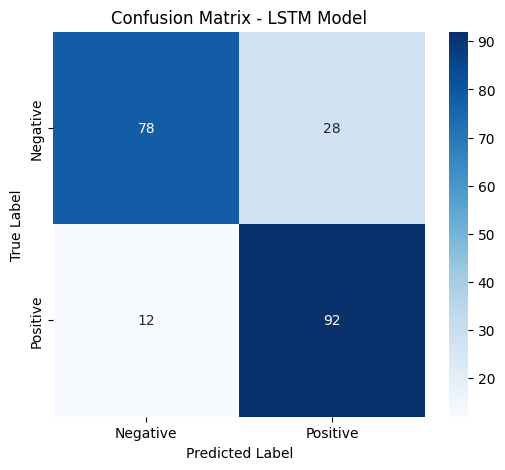

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict using the best LSTM model
y_pred_lstm = best_model_lstm.predict(x_test)  # Get probability scores

# Convert probabilities to binary predictions (threshold = 0.5)
y_pred_lstm = (y_pred_lstm > 0.5).astype(int)

# Compute confusion matrix
cm_lstm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LSTM Model")
plt.show()
